# **MovieLens Movie Recommendation using Matrix Factorization**

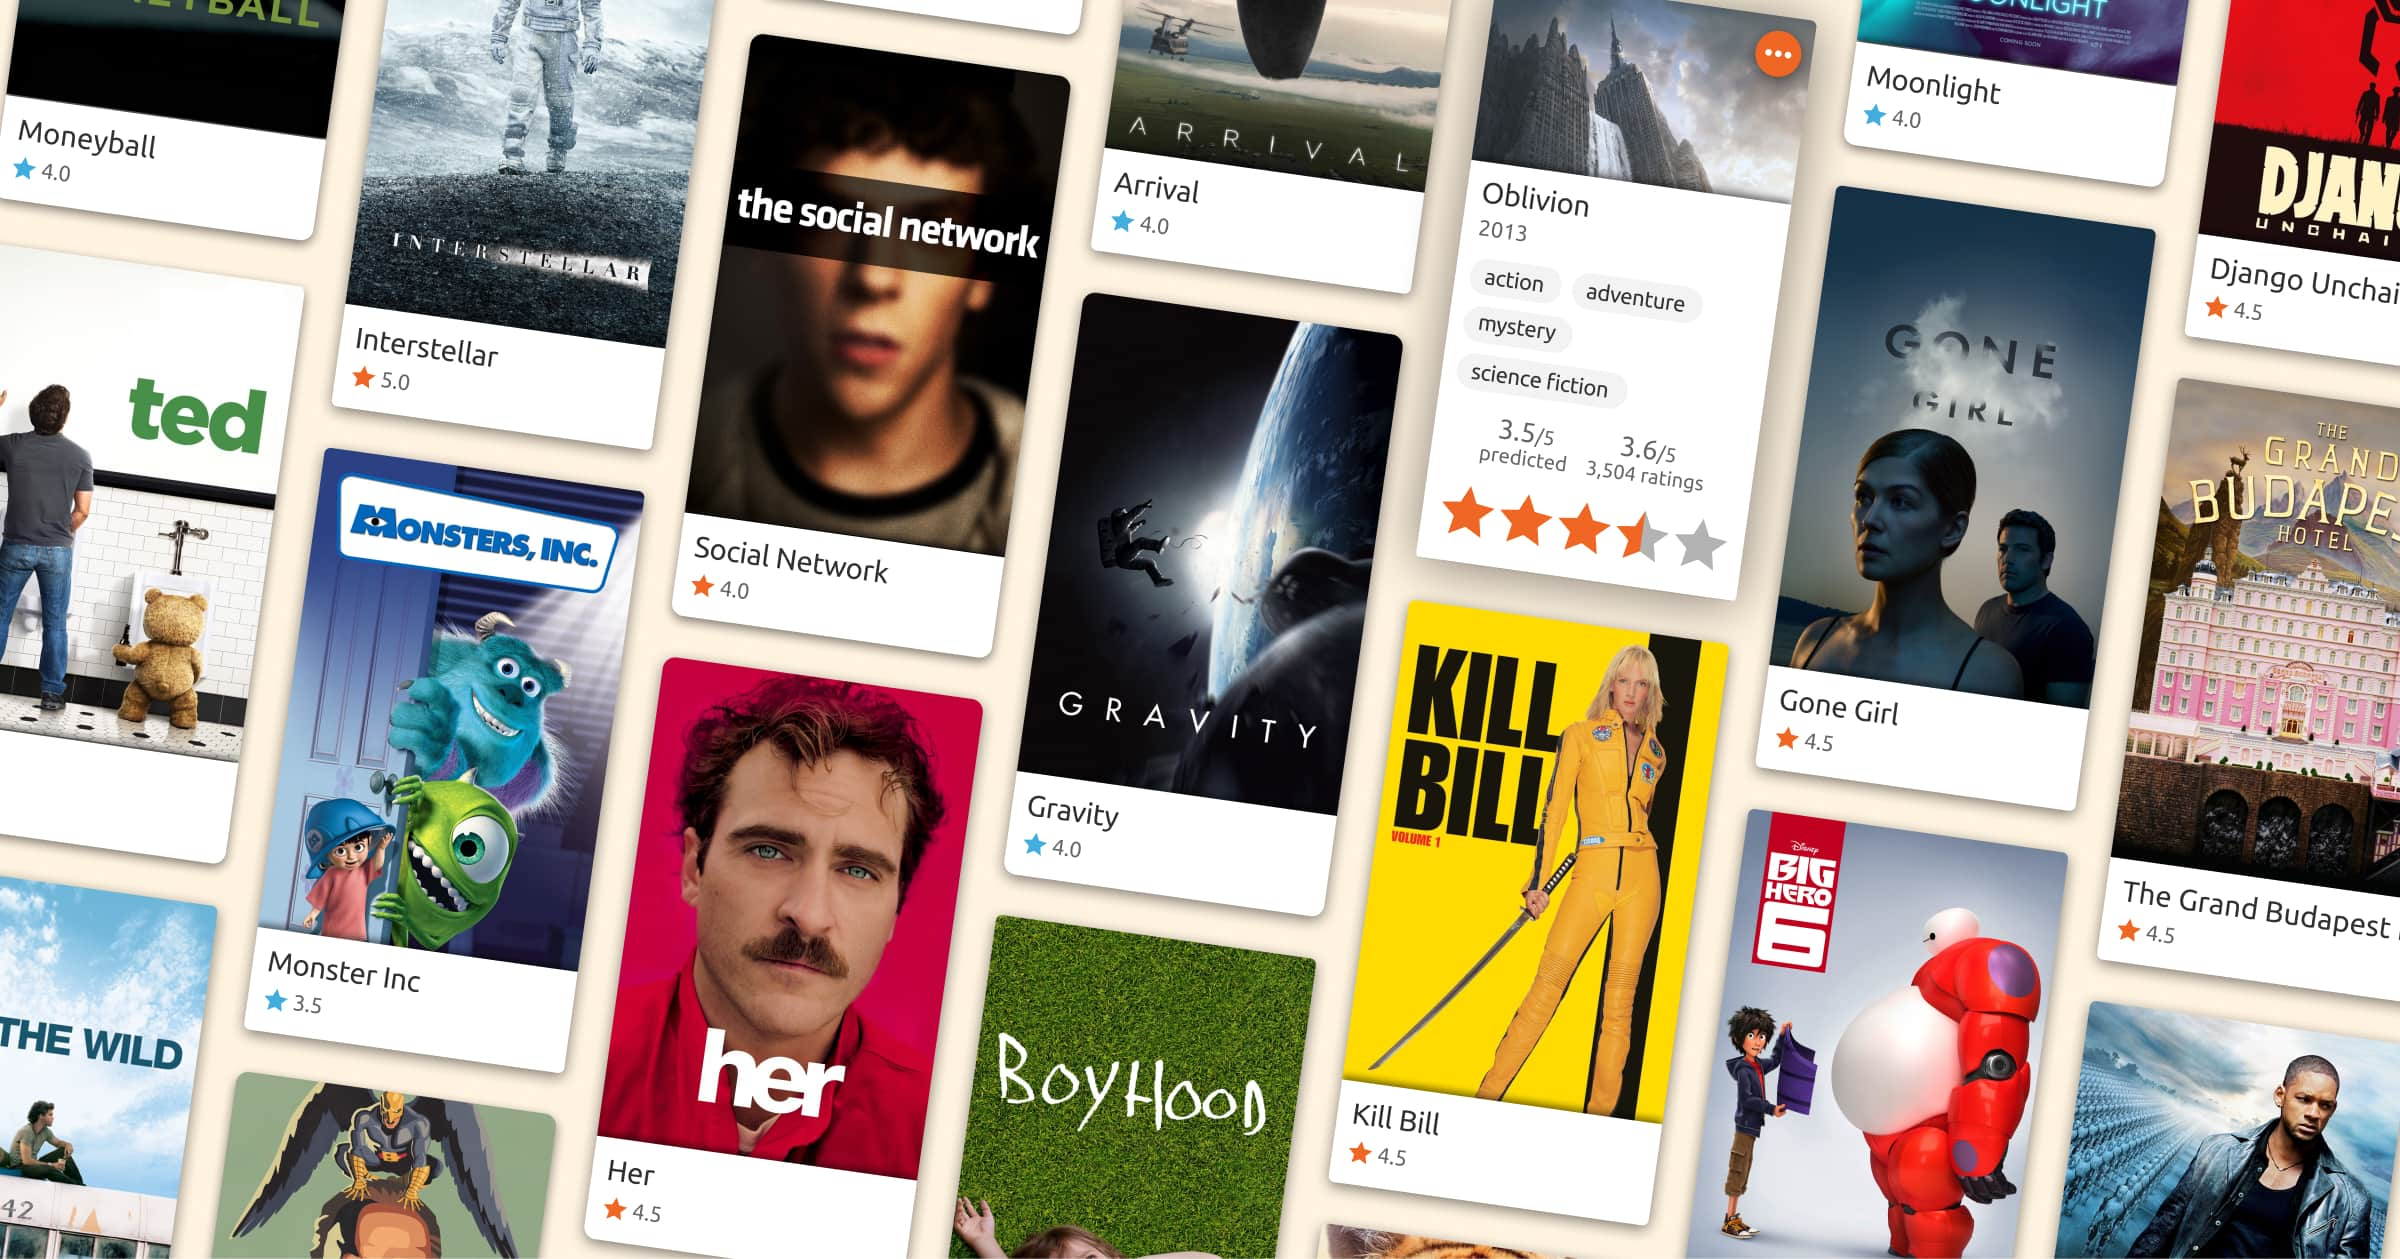

Recommender systems are part of our daily life. It doesn't matter where. We do appreciate a good suggestion. Recommender systems are a win-win game for both service providers' and users' sides. They reduce transaction costs of finding and selecting items in an online shopping environment. 

The two most common types of recommender systems are ***Content-Based*** and ***Collaborative Filtering***. While the first one uses item features to recommend the other items similar to what the user likes, Collaborative Filtering uses the "wisdom of the crowd" to recommend. 

Collaborative Filtering methods or "CF" methods are more common because they can lead to better results and are relatively easy to implement. CF can be divided into memory-based and model-based techniques. In this notebook, I will focus on implementing the low-rank matrix factorization method as part of the model-based CF technique to recommend top K movies to any desired user.


Since there are not many user-rating movie datasets out there, I'll use a relatively small Movielens dataset which is available [here](https://grouplens.org/datasets/movielens/latest/).

# Import Libraries

In [1]:
# Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# For matrix factorization
from scipy.sparse.linalg import svds

# Load Datasets

In [6]:
# Load ratings dataset
rating = pd.read_csv(r"C:\Bakalaurs_praktiskais\Bakalaura-darbs\ratings.csv")
rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
# More than 100,000 ratings
rating.shape

(100836, 4)

In [5]:
# Load movies dataset
movie = pd.read_csv('C:\Bakalaurs_praktiskais\Bakalaura-darbs\movies.csv')
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
# More than 9700 movies
movie.shape

(9742, 3)

In [9]:
# Merge two datasets to have better picture
df = pd.merge(rating, movie, on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [10]:
df.shape

(100836, 6)

In [11]:
# Check if any NaN values
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

# Exploratory Data Analysis

In [12]:
# Create a dataset to explore
eda_rating = pd.DataFrame(df.groupby('title')['rating'].mean())

In [13]:
# Add number of ratings to the dataset
eda_rating['count of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())

In [14]:
# This is how it looks like
eda_rating.head()

,rating,count of ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


In [15]:
eda_rating.shape

(9719, 2)

In [16]:
# Top 10 most rated movies in our dataset
eda_rating.sort_values('count of ratings', ascending=False).head(10)

,rating,count of ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


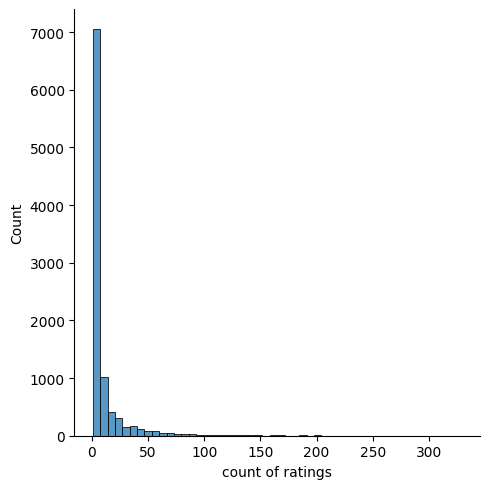

In [17]:
# Check the ratings count distribution in our dataset
sns.displot(data=eda_rating, x='count of ratings', bins=50)

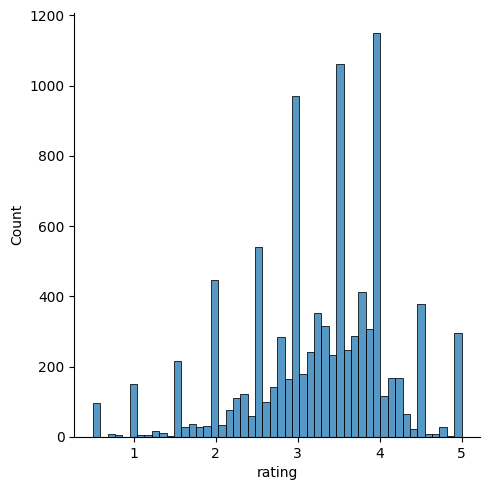

In [18]:
# How do peaple rate movies?
sns.displot(data=eda_rating, x='rating', bins=50)

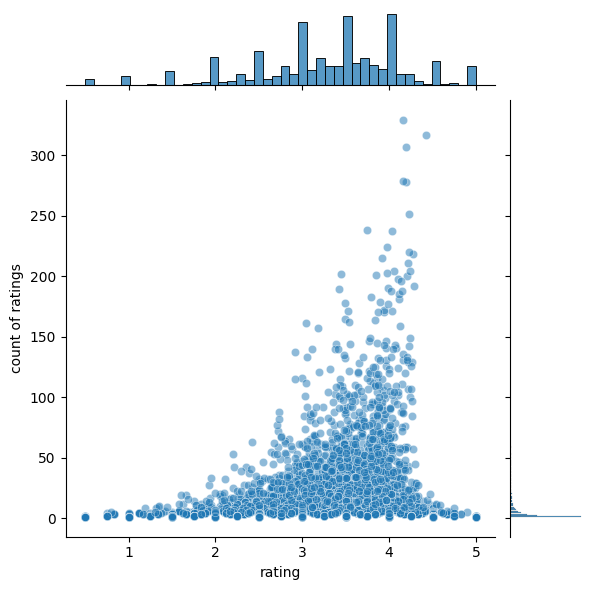

In [19]:
# Overview in one picture
sns.jointplot(x='rating',y='count of ratings',data=eda_rating,alpha=0.5)

# Matrix Factorization

In [20]:
# Pivot to summarise and count
mtrx_df = rating.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
mtrx_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Demean the data
mtrx = mtrx_df.to_numpy()
ratings_mean = np.mean(mtrx, axis = 1)
normalized_mtrx = mtrx - ratings_mean.reshape(-1, 1)

In [22]:
normalized_mtrx

array([[ 3.89582476, -0.10417524,  3.89582476, ..., -0.10417524,
        -0.10417524, -0.10417524],
       [-0.01177499, -0.01177499, -0.01177499, ..., -0.01177499,
        -0.01177499, -0.01177499],
       [-0.00976964, -0.00976964, -0.00976964, ..., -0.00976964,
        -0.00976964, -0.00976964],
       ...,
       [ 2.23215755,  1.73215755,  1.73215755, ..., -0.26784245,
        -0.26784245, -0.26784245],
       [ 2.98755656, -0.01244344, -0.01244344, ..., -0.01244344,
        -0.01244344, -0.01244344],
       [ 4.50611888, -0.49388112, -0.49388112, ..., -0.49388112,
        -0.49388112, -0.49388112]])

In [23]:
# Singular value decomposition
U, sigma, Vt = svds(normalized_mtrx, k = 50)

In [24]:
# Convert to diagonal form
sigma = np.diag(sigma)

In [25]:
# Make predictions for any user
all_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + ratings_mean.reshape(-1, 1)

In [26]:
preds_df = pd.DataFrame(all_predicted_ratings, columns = mtrx_df.columns)

In [27]:
preds_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,...,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
1,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,...,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
2,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,...,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
3,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,...,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
4,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,...,-0.008042,-0.007419,-0.008664,-0.008664,-0.008042,-0.008664,-0.008042,-0.008042,-0.008042,-0.010127


# Recommendations

In [29]:
def recommend_movies(preds_df, userId, movie, ratings_df, num_recommendations=5):
    '''Recommend top K movies to any chosen user

    Args:
    preds_df: prediction dataframe obtained from matrix factorization
    userId: chosen user
    movie: movie dataframe
    ratings_df: rating dataframe
    num_recommendations: desired number of recommendations

    Return:
    user_rated: movies that user already rated
    recommendations: final recommendations

    '''
    # Get user id, keep in mind index starts from zero
    user_row_number = userId-1 
    # Sort user's predictons
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) 
    # List movies user already rated
    user_data = ratings_df[ratings_df.userId == (userId)]
    user_rated = (user_data.merge(movie, how = 'left', left_on = 'movieId', right_on = 'movieId').
                  sort_values(['rating'], ascending=False)
                 )
    
    # f'User {userId} has already rated {user_rated.shape[0]} films.'

    recommendations = (movie[~movie['movieId'].isin(user_rated['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
               rename(columns = {user_row_number: 'Predictions'}).
               sort_values('Predictions', ascending = False).
               iloc[:num_recommendations, :-1]
                      )

    return user_rated, recommendations

In [30]:
# Get lists of already-rated movies and recommendations based on random choice
already_rated, predictions = recommend_movies(preds_df, 100, movie, rating, 10)

In [31]:
# List of already-rated movies
already_rated.head(10)

,userId,movieId,rating,timestamp,title,genres
86,100,1958,5.0,1100186258,Terms of Endearment (1983),Comedy|Drama
101,100,2423,5.0,1100186118,Christmas Vacation (National Lampoon's Christm...,Comedy
137,100,5620,5.0,1100186982,Sweet Home Alabama (2002),Comedy|Romance
55,100,1101,5.0,1100184137,Top Gun (1986),Action|Romance
125,100,4041,5.0,1100184235,"Officer and a Gentleman, An (1982)",Drama|Romance
70,100,1307,4.5,1100183745,When Harry Met Sally... (1989),Comedy|Romance
84,100,1912,4.5,1100186251,Out of Sight (1998),Comedy|Crime|Drama|Romance|Thriller
82,100,1777,4.5,1100184536,"Wedding Singer, The (1998)",Comedy|Romance
81,100,1680,4.5,1100184264,Sliding Doors (1998),Drama|Romance
80,100,1678,4.5,1100186254,"Joy Luck Club, The (1993)",Drama|Romance


In [32]:
# Recommendations for desired user
predictions

,movieId,title,genres
1202,1704,Good Will Hunting (1997),Drama|Romance
895,1259,Stand by Me (1986),Adventure|Drama
409,500,Mrs. Doubtfire (1993),Comedy|Drama
358,440,Dave (1993),Comedy|Romance
1185,1682,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi
29,39,Clueless (1995),Comedy|Romance
1991,2797,Big (1988),Comedy|Drama|Fantasy|Romance
112,150,Apollo 13 (1995),Adventure|Drama|IMAX
2082,2918,Ferris Bueller's Day Off (1986),Comedy
1209,1721,Titanic (1997),Drama|Romance
